In [9]:
import pandas as pd
import numpy as np
import math
import datetime
import FinanceDataReader as fdr
from matplotlib import pyplot as plt

In [2]:
stock_list = ['005930', '000660', '207940', '035420', '068270', '051910', '051900', '028260', '005380', '006400']
stock_name = ['삼성전자', 'SK하이닉스', '삼성바이오로직스', 'NAVER', '셀트리온', 'LG화학', 'LG생활건강', '삼성물산', '현대차', '삼성SDI']

In [3]:
df_point = pd.DataFrame(columns=['StockName', 'DateK', 'DateA', 'DateB', 'DateC', 'DateD', 'Gamma'])
for idx in range(len(stock_list)):
    df = fdr.DataReader(stock_list[idx], '2019-01-01', '2019-12-31')

    data = df.reset_index()
    data['Date'] = data['Date'].apply(lambda x : x.strftime('%Y-%m-%d'))
    data['Close_ch'] = data['Close'].shift(+1)
    data['rpv'] = ((data['Close'] / data['Close_ch']) - 1) * data['Volume']
    data['SMA50_Volume'] = data.Volume.rolling(50).mean()
    data['SMA50_rpv'] = data.rpv.rolling(50).mean()

    T = 0
    i = 1
    t = 51
    stock = False

    now = datetime.datetime.now()
    print("Stock : ", stock_name[idx])
    print("start : ", now.strftime("%Y-%m-%d %H:%M:%S"))
    while t < len(data)-T:
        #print('t = ', t)

        dat = data.loc[t:]
        Dk = dat.loc[t]['Date']
        Pk = dat.loc[t]['Close']   

        # search for region K to A
        k = 25
        while k > 15:
            #print('Searching SETUP with width = ', k)

            datA = dat.loc[:t+k] # Dk = t

            # first find absolute maxima point A
            Da_index = datA[datA['Close'] == max(datA['Close'])]['Date'].index[0]
            Da_value = datA[datA['Close'] == max(datA['Close'])]['Date'].values[0]

            Pa_index = datA[datA['Close'] == max(datA['Close'])]['Close'].index[0]
            Pa_value = datA[datA['Close'] == max(datA['Close'])]['Close'].values[0]

            uprv1 = abs(datA.loc[t:Da_index].loc[datA['rpv'] > 0, :]['rpv'].mean()) # na 있으면 제외해야함
            dprv1 = abs(datA.loc[t:Da_index].loc[datA['rpv'] <= 0, :]['rpv'].mean()) # na 있으면 제외해야함

            if (dprv1 == 'NaN') | (dprv1 == 0):
                dprv1 = datA['SMA50_rpv'].mean()   

            alpha1 = uprv1/dprv1
            #delta = Pa_index/t # Pk의 index는 t
            delta = Pa_value/Pk

            if (delta > 1) & (alpha1 > 1):
                #print('Okay good setup! Lets move on now')

                a = 40

                while a > 10:
                    #print('Lets search for LEFT SIDE CUP with width = ', a)

                    datB = dat.loc[Da_index:Da_index+a]

                    Db_index = datB[datB['Close'] == min(datB['Close'])]['Date'].index[0]
                    Db_value = datB[datB['Close'] == min(datB['Close'])]['Date'].values[0]

                    Pb_index = datB[datB['Close'] == min(datB['Close'])]['Close'].index[0]
                    Pb_value = datB[datB['Close'] == min(datB['Close'])]['Close'].values[0]

                    avg_vol = datB['Volume'].mean()
                    avg_ma_vol = data['SMA50_Volume'].mean()

                    if (Pb_value < Pa_value) & (avg_vol < avg_ma_vol):
                        #print("Voila! You found the bottom, it's all uphill from here")

                        b = a

                        while b > round(a/3):
                            #print("Let's search for RIGHT SIDE CUP with width = ", b)

                            datC = dat.loc[Db_index:Db_index+b+1]

                            Dc_index = datC[datC['Close'] == max(datC['Close'])]['Date'].index[0]
                            Dc_value = datC[datC['Close'] == max(datC['Close'])]['Date'].values[0]

                            Pc_index = datC[datC['Close'] == max(datC['Close'])]['Close'].index[0]
                            Pc_value = datC[datC['Close'] == max(datC['Close'])]['Close'].values[0]

                            uprv2 = abs(datC.loc[datC['rpv'] > 0, :]['rpv'].mean()) # na 있으면 제외해야함
                            dprv2 = abs(datC.loc[datC['rpv'] <= 0, :]['rpv'].mean()) # na 있으면 제외해야함

                            if (dprv2 == 'NaN') | (dprv2 == 0):
                                dprv2 = datC['SMA50_rpv'].mean()      

                            alpha2 = uprv2/dprv2

                            if (Pc_value > Pb_value) & (alpha2 > 1):
                                #print("Almost there... be patient now! :D")

                                # search for region C to D
                                c = b/2

                                while c > round(b/4):
                                    #print("Let's search for the handle now with width = ", c)
                                    #print(t, " ", k, " ", a, " ", b, " ", c)

                                    datD = dat.loc[Dc_index:Dc_index+c+1]

                                    Dd_index = datD[datD['Close'] == min(datD['Close'])]['Date'].index[0]
                                    Dd_value = datD[datD['Close'] == min(datD['Close'])]['Date'].values[0]

                                    Pd_index = datD[datD['Close'] == min(datD['Close'])]['Close'].index[0]
                                    Pd_value = datD[datD['Close'] == min(datD['Close'])]['Close'].values[0]

                                    uprv3 = abs(datD.loc[datD['rpv'] > 0, :]['rpv'].mean()) # na 있으면 제외해야함
                                    dprv3 = abs(datD.loc[datD['rpv'] <= 0, :]['rpv'].mean()) # na 있으면 제외해야함

                                    if (dprv3 == 'NaN') | (dprv3 == 0):
                                        dprv3 = datD['SMA50_rpv'].mean()      

                                    beta = uprv2/dprv3

                                    if (Pd_value <= Pc_value) & (Pd_value > 0.8 * Pc_value + 0.2 * Pb_value) & (beta > 1):
                                        if (Pc_value <= Pa_value) & (Pd_value > Pb_value):
                                            stock = True

                                            gamma = math.log(alpha2) + math.log(beta) + delta

                                            df_point.loc[len(df_point)] = [stock_name[idx], Dk, Da_value, Db_value, Dc_value, Dd_value, gamma]

                                            #print("Hurrah! Got "+str(i)+" hits!")

                                            k = 15
                                            a = 10
                                            b = round(a/3)
                                            c = round(b/4)
                                            i = i+1
                                            t = t+15

                                    c = c-1

                            b = b-1

                    a = a-1

            k = k-1

        t = t + 1

    now = datetime.datetime.now()
    print("end : ", now.strftime("%Y-%m-%d %H:%M:%S"))    



Stock :  삼성전자
start :  2020-05-14 20:07:20
end :  2020-05-14 20:45:19
Stock :  SK하이닉스
start :  2020-05-14 20:45:19
end :  2020-05-14 21:16:34
Stock :  삼성바이오로직스
start :  2020-05-14 21:16:34
end :  2020-05-14 21:52:01
Stock :  NAVER
start :  2020-05-14 21:52:01
end :  2020-05-14 22:44:55
Stock :  셀트리온
start :  2020-05-14 22:44:55
end :  2020-05-14 22:54:30
Stock :  LG화학
start :  2020-05-14 22:54:30
end :  2020-05-14 23:29:59
Stock :  LG생활건강
start :  2020-05-14 23:29:59
end :  2020-05-15 00:02:34
Stock :  삼성물산
start :  2020-05-15 00:02:34
end :  2020-05-15 00:19:57
Stock :  현대차
start :  2020-05-15 00:19:57
end :  2020-05-15 00:50:15
Stock :  삼성SDI
start :  2020-05-15 00:50:15
end :  2020-05-15 01:41:26


In [4]:
df_point2 = df_point.copy()

In [5]:
df_point2.to_csv('Cup and Handle 10 Stocks_0514.csv')

In [6]:
#df_point2['StockCode'] = df_point2[df_op]
df_point2['StockCode'] = 'nan'
code_lst = []
for i in range(len(stock_name)):
    df_stock = df_point2[df_point2['StockName'] == stock_name[i]]
    for j in range(len(df_stock)):
        code_lst.append(stock_list[i])
df_point2['StockCode'] = code_lst     

df_point3 = pd.DataFrame(columns=['StockName', 'DateK', 'DateA', 'DateB', 'DateC', 'DateD', 'Gamma', 'StockCode'])

for i in range(len(stock_list)):
    df_stock = df_point2[df_point2['StockName'] == stock_name[i]]
    best_point = df_stock[df_stock['Gamma'] == max(df_stock['Gamma'])]
    idx = len(df_point3)
    df_point3.loc[idx] = df_point2.loc[best_point.index[0]]

### 10개 종목

In [7]:
df_point3

,StockName,DateK,DateA,DateB,DateC,DateD,Gamma,StockCode
0,삼성전자,2019-05-16,2019-06-21,2019-08-08,2019-09-05,2019-09-05,3.598903,005930
1,SK하이닉스,2019-06-17,2019-07-22,2019-08-06,2019-09-02,2019-09-03,1.254233,000660
2,삼성바이오로직스,2019-08-12,2019-09-19,2019-09-30,2019-10-08,2019-10-11,3.766320,207940
3,NAVER,2019-10-10,2019-11-14,2019-11-22,2019-12-16,2019-12-18,2.750840,035420
4,셀트리온,2019-09-24,2019-10-29,2019-12-11,2019-12-27,2019-12-30,3.807858,068270
5,LG화학,2019-05-24,2019-07-01,2019-07-09,2019-07-16,2019-07-16,3.915884,051910
6,LG생활건강,2019-08-22,2019-09-30,2019-10-29,2019-10-31,2019-11-01,3.252757,051900
7,삼성물산,2019-07-08,2019-07-23,2019-08-08,2019-08-23,2019-08-26,3.384659,028260
8,현대차,2019-08-19,2019-09-25,2019-10-23,2019-11-01,2019-11-06,3.084689,005380
9,삼성SDI,2019-03-28,2019-05-03,2019-05-29,2019-06-13,2019-06-21,3.381948,006400


#### 삼성전자

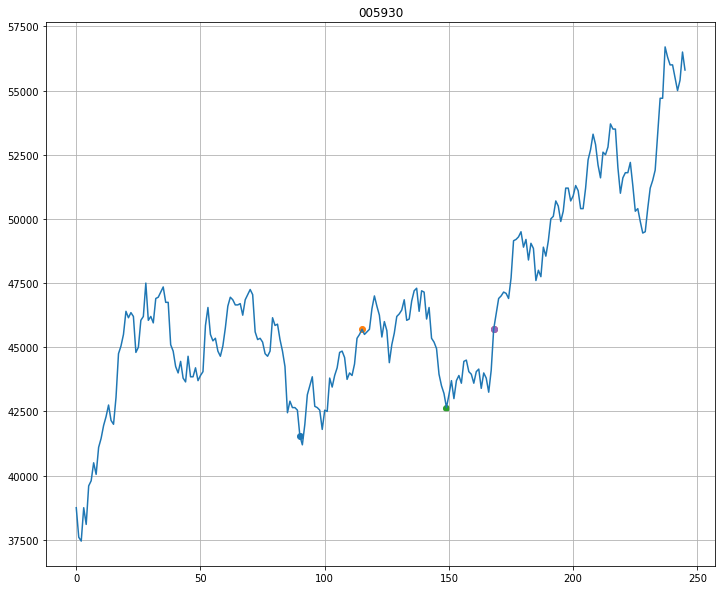

In [10]:
i = 0
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]
plt.rcParams['figure.figsize'] = [12, 10]

plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### SK하이닉스

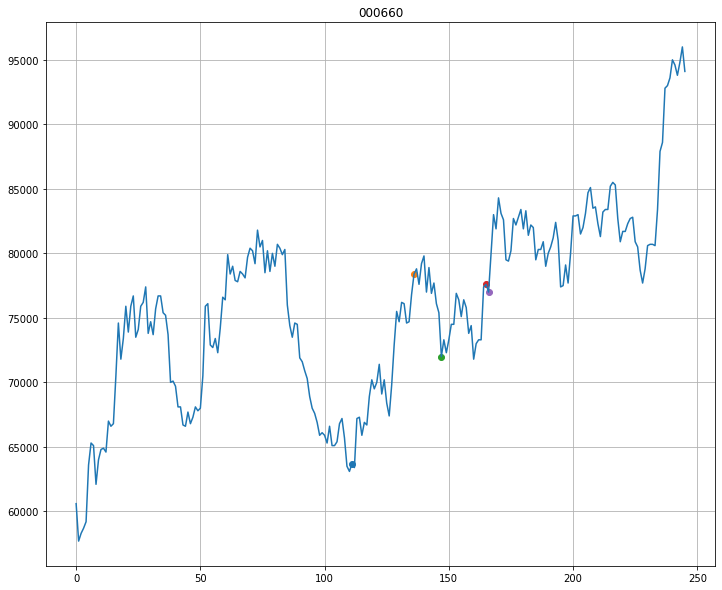

In [11]:
i = 1
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]
plt.rcParams['figure.figsize'] = [12, 10]

plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### 삼성바이오로직스

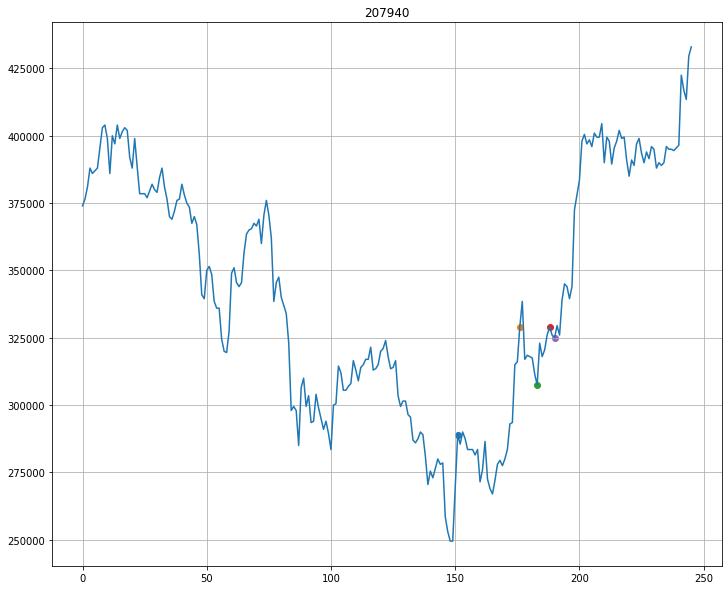

In [12]:
i = 2
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]
plt.rcParams['figure.figsize'] = [12, 10]

plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### NAVER

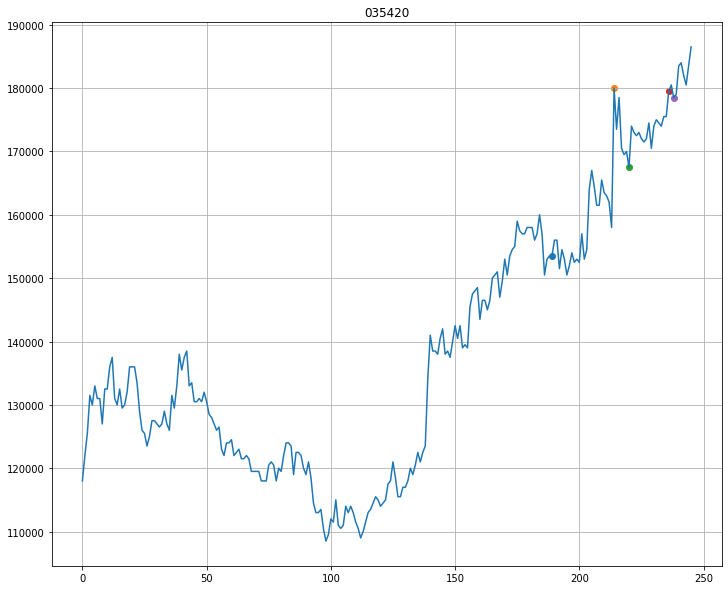

In [13]:
i = 3
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### 셀트리온

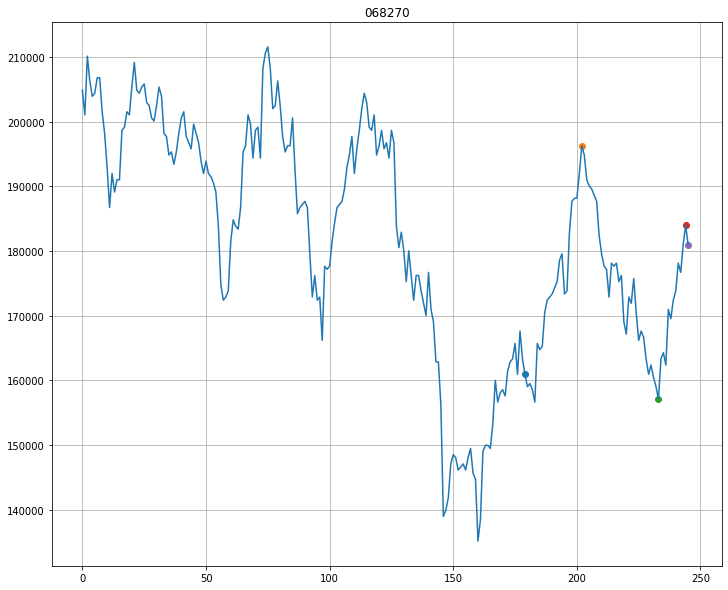

In [14]:
i = 4
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### LG화학

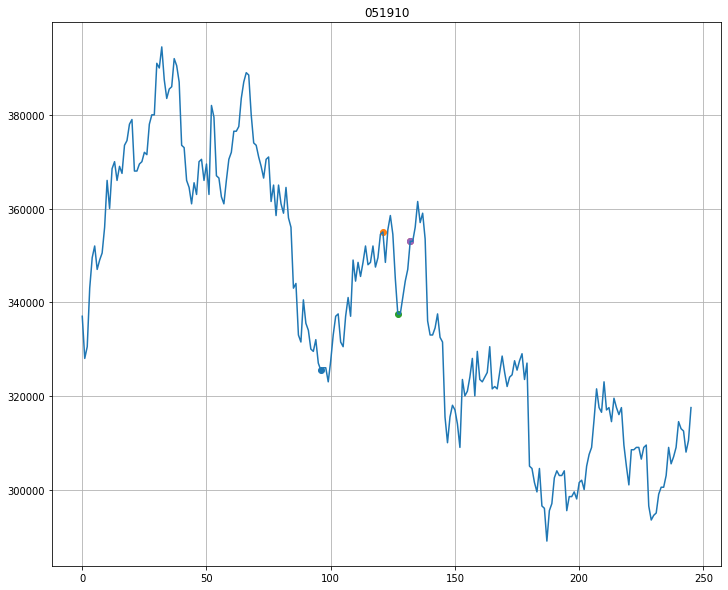

In [15]:
i = 5
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### LG 생활건강

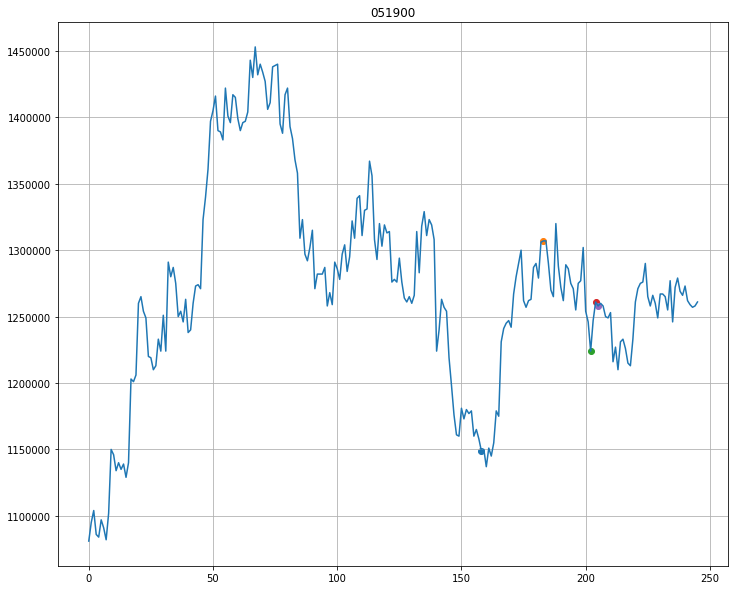

In [16]:
i = 6
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### 삼성물산

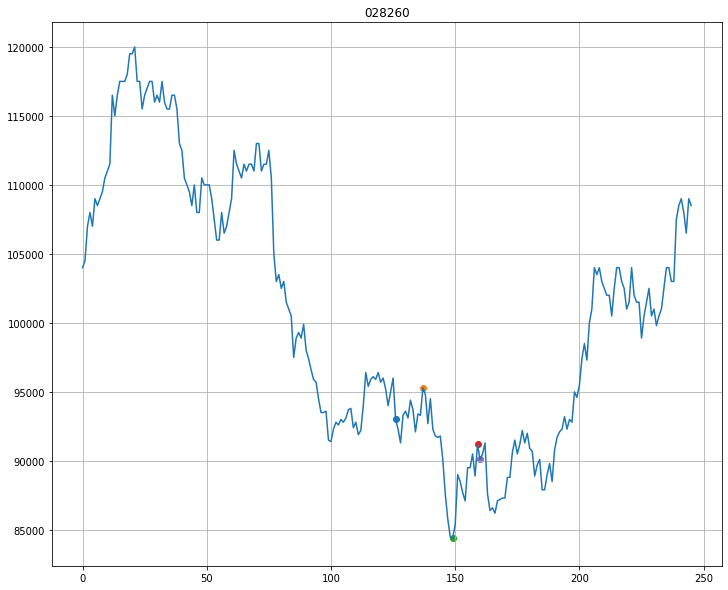

In [17]:
i = 7
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### 현대차

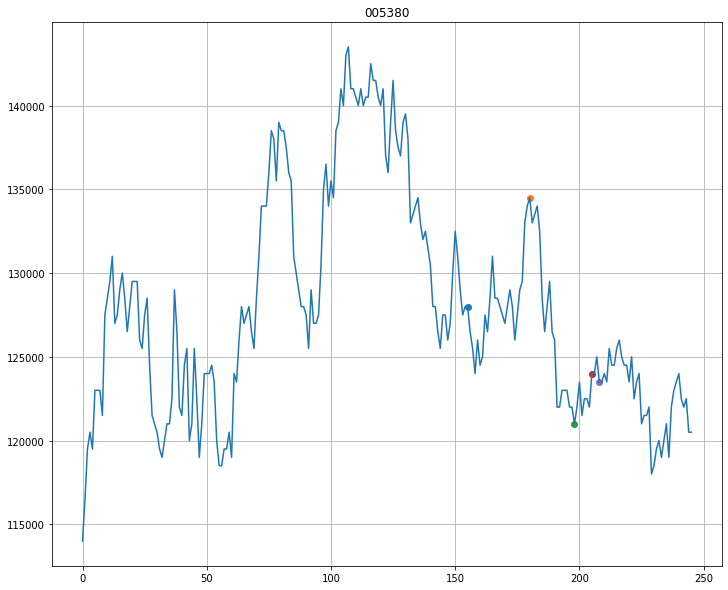

In [18]:
i = 8
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()

#### 삼성 SDI

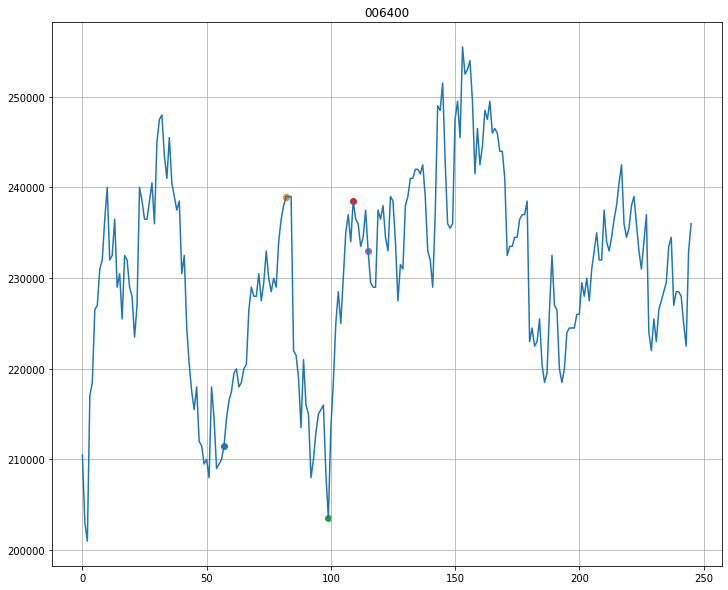

In [19]:
i = 9
df = fdr.DataReader(df_point3.loc[i]['StockCode'], '2019-01-01', '2019-12-31')
data = df.reset_index()
stock_BP = df_point3[df_point3['StockCode'] == stock_list[i]]

plt.rcParams['figure.figsize'] = [12, 10]
plt.title(stock_list[i])
plt.plot(data['Close'])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateK']].index[0], data[data['Date'] == stock_BP.loc[i]['DateK']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateA']].index[0], data[data['Date'] == stock_BP.loc[i]['DateA']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateB']].index[0], data[data['Date'] == stock_BP.loc[i]['DateB']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateC']].index[0], data[data['Date'] == stock_BP.loc[i]['DateC']]['Close'].values[0])
plt.scatter(data[data['Date'] == stock_BP.loc[i]['DateD']].index[0], data[data['Date'] == stock_BP.loc[i]['DateD']]['Close'].values[0])

plt.grid()